In [1]:
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [5]:
data_dir = d2l.download_extract('hotdog')
data_dir

'../data/hotdog'

In [6]:
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

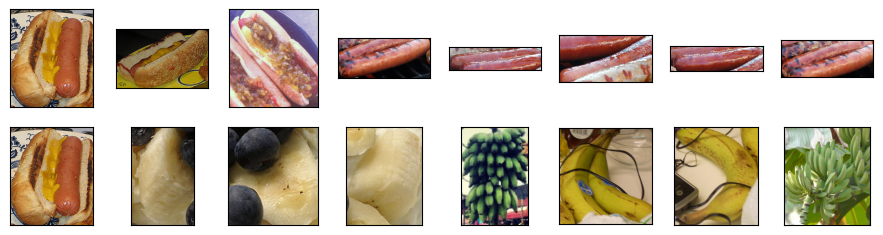

In [14]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i][0] for i in range(8)]
d2l.show_images(hotdogs+not_hotdogs, 2, 8,scale=1.4);

In [ ]:
data_loader = torch.utils.data.DataLoader(train_imgs, batch_size= 32, shuffle=False)

In [17]:
normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224, 0.225])

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),normalize]
)
test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256, 256]),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),normalize]
)

In [19]:
pretrained_net = torchvision.models.resnet18(pretrained=True)

/home/austin/.conda/envs/d2l/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/austin/.conda/envs/d2l/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/austin/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


In [20]:
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

In [24]:
finetune_net = torchvision.models.resnet18(pretrained = True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight);

/home/austin/.conda/envs/d2l/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/austin/.conda/envs/d2l/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
def train_fine_tuning(net, learning_rate, batch_size=128, 
                      num_epochs=5, param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
                            os.path.join(data_dir, 'train'), transform=train_augs), 
                            batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
                            os.path.join(data_dir, 'test'), transform=test_augs), 
                            batch_size=batch_size)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction='none')
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
                                        if name not in ['fc.weight', 'fc.bias']]
        trainer = torch.optim.SGD([{'params': params_1x},
                                                                    {'params':net.fc.parameters(),
                                                                     'lr':learning_rate*10}], 
                                                                     lr = learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr = learning_rate,
                                   weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter,  loss, trainer, num_epochs,
                    devices)
    

In [ ]:
train_fine_tuning(finetune_net, learning_rate=5e-5)

![20250119180109](https://raw.githubusercontent.com/AustinSuun/image/main/img/20250119180109.png)